# Ocean carbon fluxes

---

## Overview
The carbon cycle is a key part of ocean biogeochemistry, and more broadly Earth's climate system. Here we learn how to make maps of some key variables modeled by CESM related to the marine carbon cycle.

1. General setup
2. Subsetting
3. Processing data
4. Making maps
   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |


- **Time to learn**: 15 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import dask
import distributed
import s3fs
import netCDF4

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
ds_grid

<xarray.Dataset> Size: 11MB
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 480B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 480B 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 480B 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * nreg         (nreg) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 319.4 319.8
    ULAT         (nlat, nlon) float64 983kB -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG        (nlat, nlon) float64 983kB 321.1 322.3 323.4 ... 319.6 320.0
    DXT          (nlat, nlon) float64 983kB 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 983kB 5.94e+06 5.94e+06 ... 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 983kB 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dz           (z_t) float64 480B 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    region_name  (nreg) <U21 1kB 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 104B -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [6]:
jetstream_url = 'https://js2.jetstream-cloud.org:8001/'

s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))

# Generate a list of all files in CESM folder
s3path = 's3://pythia/ocean-bgc/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1/*'
remote_files = s3.glob(s3path)

# Open all files from folder
fileset = [s3.open(file) for file in remote_files]

# Open with xarray
ds = xr.open_mfdataset(fileset, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)

ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (nlat: 384, nlon: 320, time: 120, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Subsetting

In [7]:
variables =['FG_CO2','photoC_TOT_zint','POC_FLUX_100m']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing - global means in time and space

Pull in the functions we defined in the nutrients notebook...

In [8]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    
def global_mean(ds, ds_grid, compute_vars, normalize=True, include_ms=False):
    """
    Compute the global mean on a POP dataset. 
    Return computed quantity in conventional units.
    """

    other_vars = list(set(ds.variables) - set(compute_vars))

    # note TAREA is in cm^2, which affects units
    
    if include_ms: # marginal seas!
        surface_mask = ds_grid.TAREA.where(ds_grid.KMT > 0).fillna(0.)
    else:
        surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.)        
    
    masked_area = {
        v: surface_mask.where(ds[v].notnull()).fillna(0.) 
        for v in compute_vars
    }
    
    with xr.set_options(keep_attrs=True):
        
        dso = xr.Dataset({
            v: (ds[v] * masked_area[v]).sum(['nlat', 'nlon'])
            for v in compute_vars
        })
        
        if normalize:
            dso = xr.Dataset({
                v: dso[v] / masked_area[v].sum(['nlat', 'nlon'])
                for v in compute_vars
            })            
                
    return dso

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [9]:
ds = year_mean(ds).mean("year")

### Do some global integrals, to check if our values look reasonable

In [10]:
ds_glb = global_mean(ds, ds_grid, variables,normalize=False).compute()

# convert from nmol C/s to Pg C/yr
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset> Size: 24B
Dimensions:          ()
Data variables:
    FG_CO2           float64 8B 2.779
    photoC_TOT_zint  float64 8B 53.26
    POC_FLUX_100m    float64 8B 6.796

We can compare these values to some observationally derived values. Each of these is calculated in a different way with combinations of data and models--please reference each linked paper for detailed discussion. [Takahashi et al., 2002](https://www.sciencedirect.com/science/article/pii/S0967064502000036) estimate global air-sea CO$_2$ flux to be 2.2 (+22% or −19%) Pg C yr$^{−1}$. Our value (shown above as `FG_CO2`) is 2.779 Pg C yr$^{−1}$. This value is outside of these bounds, but still on the same order of magnitude. We note that these values are calculated over different time periods, so we also don't expect them to be an exact comparison. `photoC_TOT_zint` represents global vertically-integrated NPP; [Behrenfeld and Falkowski, 1997](https://aslopubs.onlinelibrary.wiley.com/doi/10.4319/lo.1997.42.1.0001) estimate this value to be 43.5 Pg C yr$^{−1}$. Our value is 53.26 Pg C yr$^{−1}$, which is within 22% of the observationally derived value. `POC_FLUX_100m` represents the particulate organic carbon flux at 100 m depth. [DeVries and Weber, 2017](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GB005551) calculated this flux integrated over the entire euphotic zone to be 9.1 ± 0.2 Pg C yr$^{−1}$. Since the depth ranges are different this isn't an exact comparison, but the orders of magnitude are similar. This first-pass analysis tells us that CESM is on the right track for these values.

## Make some maps

First, convert from mmol/m3 cm/s to mmol/m2/day.

In [11]:
for var in variables:
    ds[var] = ds[var] * 0.01 * 86400.

Then, make a few maps of key carbon-related variables.

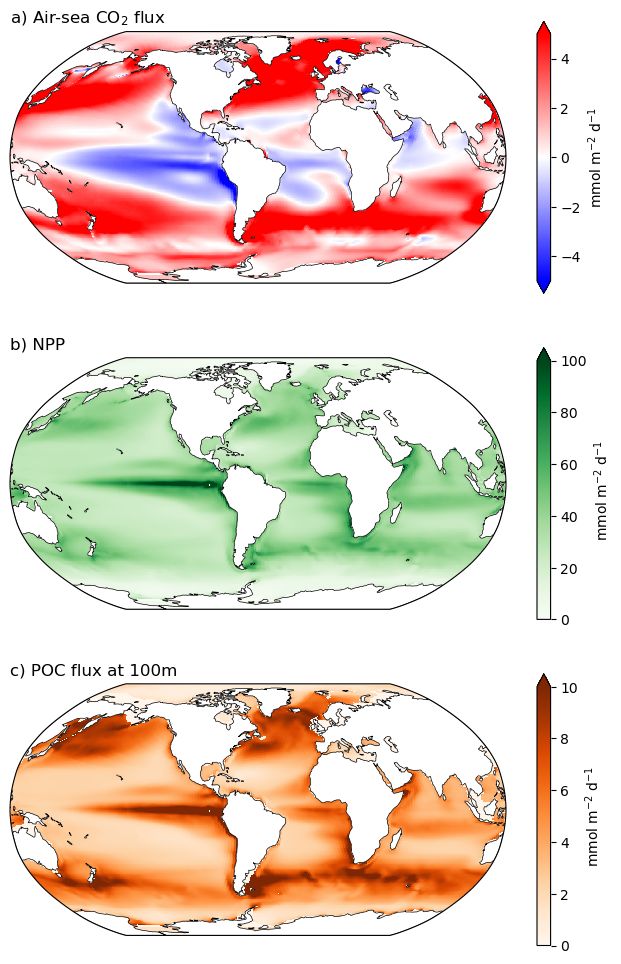

In [12]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Air-sea CO$_2$ flux', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.FG_CO2)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$')


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint)
pc=ax.pcolormesh(lon, lat, field, cmap='Greens',vmin=0,vmax=100,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) POC flux at 100m', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.POC_FLUX_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=10,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$');

And close the Dask cluster we spun up at the beginning.

In [13]:
cluster.close()

---

## Summary
You've learned how to make maps of some key quantities related to oceanic carbon.

## Resources and references
- [Sarmiento and Gruber, Chapter 8: The Carbon Cycle](https://doi.org/10.2307/j.ctt3fgxqx.12)
- [Takahashi et al., 2002](https://www.sciencedirect.com/science/article/pii/S0967064502000036)
- [Behrenfeld and Falkowski, 1997](https://aslopubs.onlinelibrary.wiley.com/doi/10.4319/lo.1997.42.1.0001)
- [DeVries and Weber, 2017](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GB005551)